
### Домашка 4.

* Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

* Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

* Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
* Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
* Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

* Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error

Загрузим файл с данными.

In [47]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data.columns

Index(['Time', 'PJME_MW', 'year', 'month', 'dayofmonth', 'quarter',
       'dayofyear', 'weekofyear', 'dayofweek', 'hour', 'is_holiday',
       'is_prev_holiday', 'is_next_holiday'],
      dtype='object')

In [48]:
data_w = data.copy().resample('W').mean()
data_w.drop(['dayofmonth','dayofweek','hour','is_holiday','is_prev_holiday','is_next_holiday','hour'], axis=1,inplace=True)
data_w.head()

,PJME_MW,year,month,quarter,dayofyear,weekofyear
Date,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,3.517483,1.0
2002-01-13,31487.386905,2002.0,1.000000,1.0,10.000000,2.0
2002-01-20,31452.880952,2002.0,1.000000,1.0,17.000000,3.0
2002-01-27,30141.529762,2002.0,1.000000,1.0,24.000000,4.0
2002-02-03,29196.488095,2002.0,1.428571,1.0,31.000000,5.0


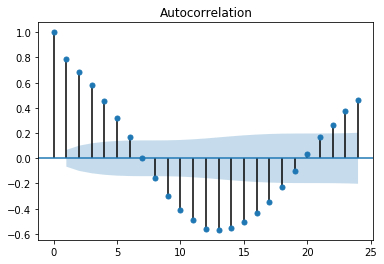

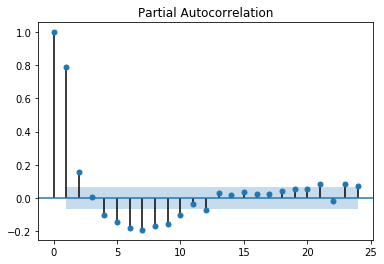

In [49]:
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=24)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=24)
plt.show()

In [35]:
first_diff =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

In [36]:
first_diff_w =(first_diff) / data_w.iloc[1:,0].values
data_w['diff1_w'] = 0
data_w['diff1_w'] =  data_w['diff1_w'].astype('float') 
data_w['diff1_w'].values[1:] = np.array(first_diff_w).astype('float32')

In [37]:
first_diff_l =np.log(data_w.iloc[1:,0].values) 
data_w['diff1_l'] = 0
data_w['diff1_l'] =  data_w['diff1_l'].astype('float') 
data_w['diff1_l'].values[1:] = first_diff_l

А теперь добавим еще и экспонентциальную среднюю. Медленную, т.к. интересная информация лежит на уровне сезонных колебаний цены.

In [38]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)


В итоге данные примут вид 

In [39]:
data_w.columns

Index(['PJME_MW', 'year', 'month', 'quarter', 'dayofyear', 'weekofyear',
       'diff1', 'diff1_w', 'diff1_l', 'exp_0_05'],
      dtype='object')

In [41]:
data_w.head()


,PJME_MW,year,month,quarter,dayofyear,weekofyear,diff1,diff1_w,diff1_l,exp_0_05
Date,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,3.517483,1.0,0.000000,0.000000,0.000000,32392.160839
2002-01-13,31487.386905,2002.0,1.000000,1.0,10.000000,2.0,-904.773926,-0.028734,10.357342,32346.922142
2002-01-20,31452.880952,2002.0,1.000000,1.0,17.000000,3.0,-34.505951,-0.001097,10.356246,32302.220083
2002-01-27,30141.529762,2002.0,1.000000,1.0,24.000000,4.0,-1311.351196,-0.043506,10.313659,32194.185567
2002-02-03,29196.488095,2002.0,1.428571,1.0,31.000000,5.0,-945.041687,-0.032368,10.281804,32044.300693


## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [52]:
from sklearn.preprocessing import StandardScaler

scl_target=StandardScaler() 
p = 12
h = 4
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(850, 1)

In [53]:
scl_x=StandardScaler() 

X = data_d.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(850, 6)

In [61]:
X[:7,14]=0

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.


In [54]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))


F-test=1.00,  I=0
F-test=0.06,  I=1
F-test=0.02,  I=2
F-test=0.02,  I=3
F-test=0.02,  I=4
F-test=0.02,  I=5


Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]), а кроме этого интересные признаки  от 14 до 21. Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [55]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(850, 5)

In [56]:
column_names = data_d.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'year', 'month', 'quarter', 'dayofyear'], dtype='object')

Лучшее множество признаков отделено в X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [58]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(850, 1)

In [74]:
column_namesp = data_d.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'diff1_l', 'd_w7', 'exp_0_08'], dtype='object')

Наконец, третий вариант - применим выделение признаков через построение модели. Помним, что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [59]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(850, 3)

Сравним результаты:


In [60]:
[X_new1[10:15,:], X_new2[10:15,:],X_new3[10:15,:]]

[array([[-0.28145941, -1.6699615 , -0.14739733, -0.45711627, -0.24612618],
        [ 0.08924639, -1.6699615 , -0.14739733, -0.45711627, -0.17801255],
        [ 0.11504528, -1.6699615 , -0.14739733, -0.45711627, -0.10989893],
        [ 1.79293112, -1.6699615 , -0.14739733, -0.45711627, -0.0417853 ],
        [ 1.63518033, -1.6699615 ,  0.14969869,  0.45775525,  0.02632832]]),
 array([[-0.28145941],
        [ 0.08924639],
        [ 0.11504528],
        [ 1.79293112],
        [ 1.63518033]]),
 array([[-0.28145941, -0.14739733, -0.24612618],
        [ 0.08924639, -0.14739733, -0.17801255],
        [ 0.11504528, -0.14739733, -0.10989893],
        [ 1.79293112, -0.14739733, -0.0417853 ],
        [ 1.63518033,  0.14969869,  0.02632832]])]

In [61]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [0 1 2 3 4]
Номера признаков лучших признаков по процентной форме:  [0]
Номера признаков для выбора по модели :  [0 2 4]


Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов. Возьмем [0,6,12,14,15,22,23] признаки и перейдем к построению модели.

In [62]:
list_par=[0,1,2,3,4]
X_new = X[:,list_par]
data_d.columns[list_par]

Index(['PJME_MW', 'year', 'month', 'quarter', 'dayofyear'], dtype='object')


## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [63]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 1/06/2016

C:\Users\Gry\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


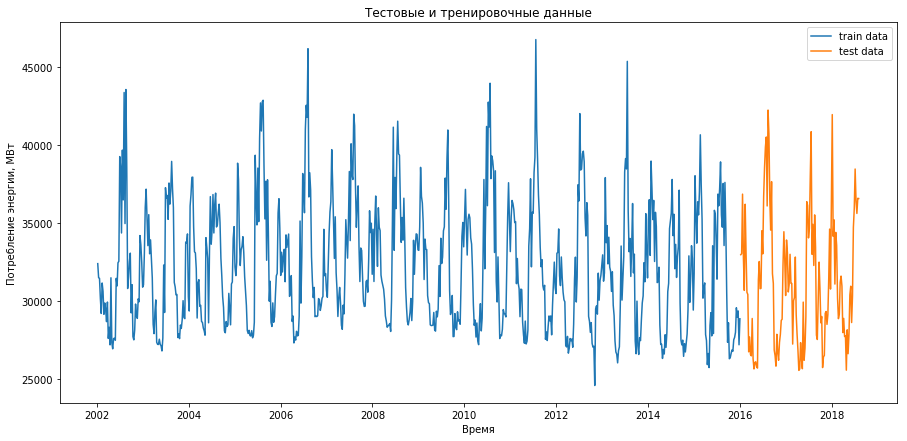

In [64]:
train, test = split_data( data_w, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [65]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [66]:
train.shape

(731, 6)

Выделим описание объекта и целевое свойство для тестовой и тренировочной частей ряда. Перейдем к построению моделей.  

# Строим Модель

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

In [68]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

Запускаем модели и смотрим , что они построят на наших примерах.

In [69]:
model_g.fit( X_train, y_train ) # 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

**Посмотрим тесты**

In [70]:
X_test.shape

(119, 5)

In [71]:
y_test_pred_g = model_g.predict(X_test)

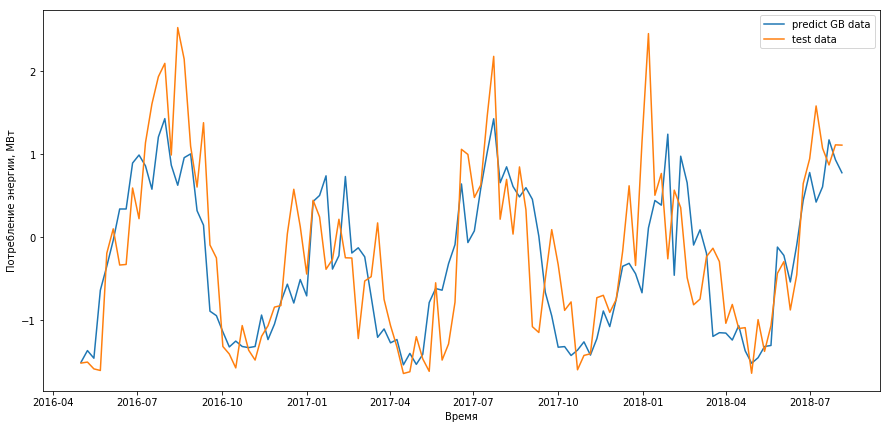

In [72]:

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

**Оценки для сравнения моделей**

Оценим промах модели, используя метрики, которые можно применять для оценки регрессий https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics:
- средне-квадратичное отклонение
- среднюю абсолютную ошибку
- коэфиициент детерминации 

In [73]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [74]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.4627473780377699 
ошибка mae  :   0.5023375254922815 
оценка R2 :   0.5658699172404014


Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Пожэтому переведем ответ решателя обратно в состояние без масштаба.

In [75]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [76]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   6.254908086759775 %
